# Mode-Turbulence Coupling: Numerical Analysis
# Plots for paper

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

## Physical Parameters

In [2]:
# mach number Ma
Ma = 0.025 ** (1/2)
K = 1
eta = 1

## Functions of Ma

In [3]:
meandeltaT = 2*np.pi

# variables for generating F1
stdF1 = eta * Ma**2 / (2 * np.pi)
limitY1 = eta / (2 * np.pi)

# variables for generating F2 and G1
stdF2 = eta * Ma**2
limitY2 = eta 


## Calculation parameters

In [4]:
L = 1
M = 10**4
M_short = 200
N = 1
m = 10**2

# dTau is the time step for the Runge Kutta Method
dTau = 2*np.pi/100
Tr = K * meandeltaT

## Calculation relations

In [5]:
 Tmax = 2 * np.pi * M
# delt = N * deltaT

## Initial Conditions

In [6]:
# initial conditions A(0)=1/2*std_F2, dA/dT(0)=0
initial_dAdT = 0
initial_AT = 0

In [7]:
n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

## Functions

In [8]:
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html
#deltaT is the length of each eddy turnover
def fundeltaT(n_bins, M):
    deltaT = []
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    # ensure that deltaT is a multiple of dTau
    for i in range(M):
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
        deltaT.append(deltaTtemp2)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    return deltaT




# Tturb adds up the delta T's
def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    time=Tturb
    time.pop(-1)
    return Tturb, time



# generating F1, F2, G1
def funF_k(F_k, std, limit):
    time = []
    y1 = 0
    for i in range(len(deltaT) - 1):
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        Ttemp = np.linspace(0, deltaT[i], deltaT[i] / dTau)
        # loops through each eddy
        for j in Ttemp:
            x = j / deltaT[i][0]
            if j == deltaT[i]:
                pass
            else:
                time.append(j+Tturb[i])
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
    return F_k, time


def funAmp(Amp, time):
    # Runge Kutta

    # A'' = f(T, A, A') = -F1 * A' - ( 1 + G1) A + F2
    # A' = u
    # u' = f(T, A, u) = -F1 * u - ( 1 + G1) A + F2
    # A'(0) = 0

    t = 0.0
    A = Amp[0]
    u = 0
    
    for i in range(len(time)):
        m1 = u
        k1 = -(F1[i] * u) - ( 1 + G1[i] ) * A + F2[i]
        m2 = u + (dTau / 2.) * k1
        t_2 = t + (dTau / 2)
        A_2 = A + (dTau / 2) * m1
        u_2 = m2
        k2 = -(F1[i] * u_2) - ( 1 + G1[i] ) * A_2 + F2[i]
        m3 = u + (dTau / 2) * k2
        t_3 = t + (dTau / 2)
        A_3 = A + (dTau / 2) * m2
        u_3 = m3
        k3 = -(F1[i] * u_3) - ( 1 + G1[i] ) * A_3 + F2[i]
        m4 = u + dTau *k3
        t_4 = t + dTau
        A_4 = A + dTau * m3
        u_4 = m4
        k4 = -(F1[i] * u_4) - ( 1 + G1[i] ) * A_4 + F2[i]
        t = t + dTau 
        A = A + (dTau / 6.) * (m1 + (2. * m2) + (2. * m3) + m4)
        u = u + (dTau / 6.) * (k1 + (2. * k2) + (2. * k3) + k4)
        Amp.append(A)

    Amp = Amp[:-1]
    
    return Amp




# Average value of Amplitude
def FunAsqr(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    return Asqr




# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA




# Root mean square
def FunRMS(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = np.sum(Asqr) / len(Asqr)
    RMS = avg**(1/2)
    return RMS




def Funplots(t, A, f1, f2, g1):

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, A, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, g1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('G\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    
    
    
def funAlpha(A, t, alpha):

    # root mean square of amplitude for T(max)
    Abar_max = FunRMS(A)

    # the number of time segments is the total time (Tmax)/delT
    numsegments = int(Tmax/int(sum(delt)/len(delt)))+1

    # 2d array containing an array for amplitudes in each segments
    ampsegments = []

    # this loop divides the total duration T(max) into equal segments of delT
    # and adds corresponding amplitudes in each time segment to amsegments 
    i=0
    for count in range(0, numsegments):
        # amp segment contains the amplitudes in the specified time segment
        ampsegment = []
        # checks if that time is withint the correct time segment
        while i < len(t)-1:
            if (t[i] < (count+1)*2*np.pi):
                # adds the corresponding amplitude if the time is within specified time segment
                ampsegment.append(A[i])
                i+=1
            else:
                # breaks the while loop if the time is outside the time segment 
                # and moves to the next time segment
                break        
        ampsegments.append(ampsegment)


    # take Abar(T) = rms(A in delT)
    # Abar is the root mean square (RMS) of A in delT   
    Abar = []    
    for ampsegment in ampsegments:
        Abar.append(FunRMS(ampsegment))

    # in order to better exhibit the distribution of the full range of values of Abar, use instead
    # alpha = log(Abar) so -4 <= alpha <= 0
    tempalpha = FunLog(Abar)
    alpha.append(tempalpha)

    alpha_max = max(tempalpha)
    alpha_min = min(tempalpha)
    
    return alpha




# flattens nested arrays into one dimensional arrays
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

##  F1, Amplitude of mode, F2 vs. Time for all runs

### Evolution 1

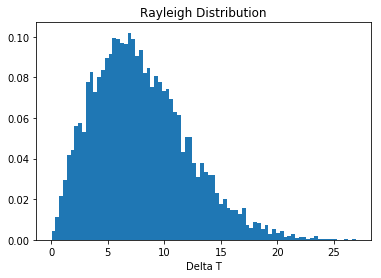

In [9]:
deltaT = fundeltaT(n_bins, M)

Tturb, time = funTturb()

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


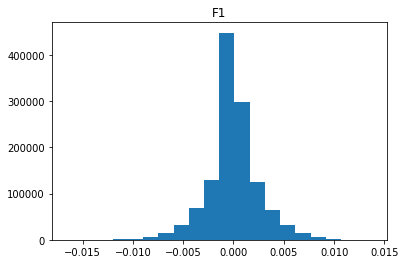

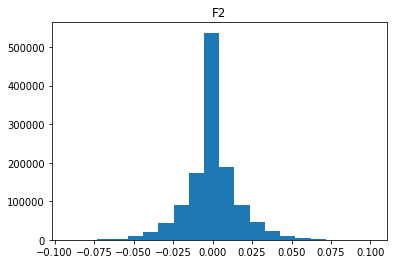

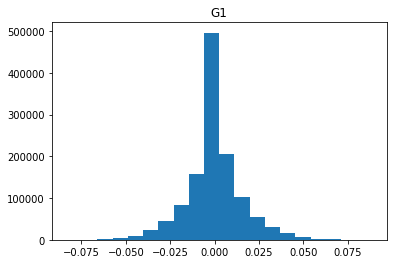

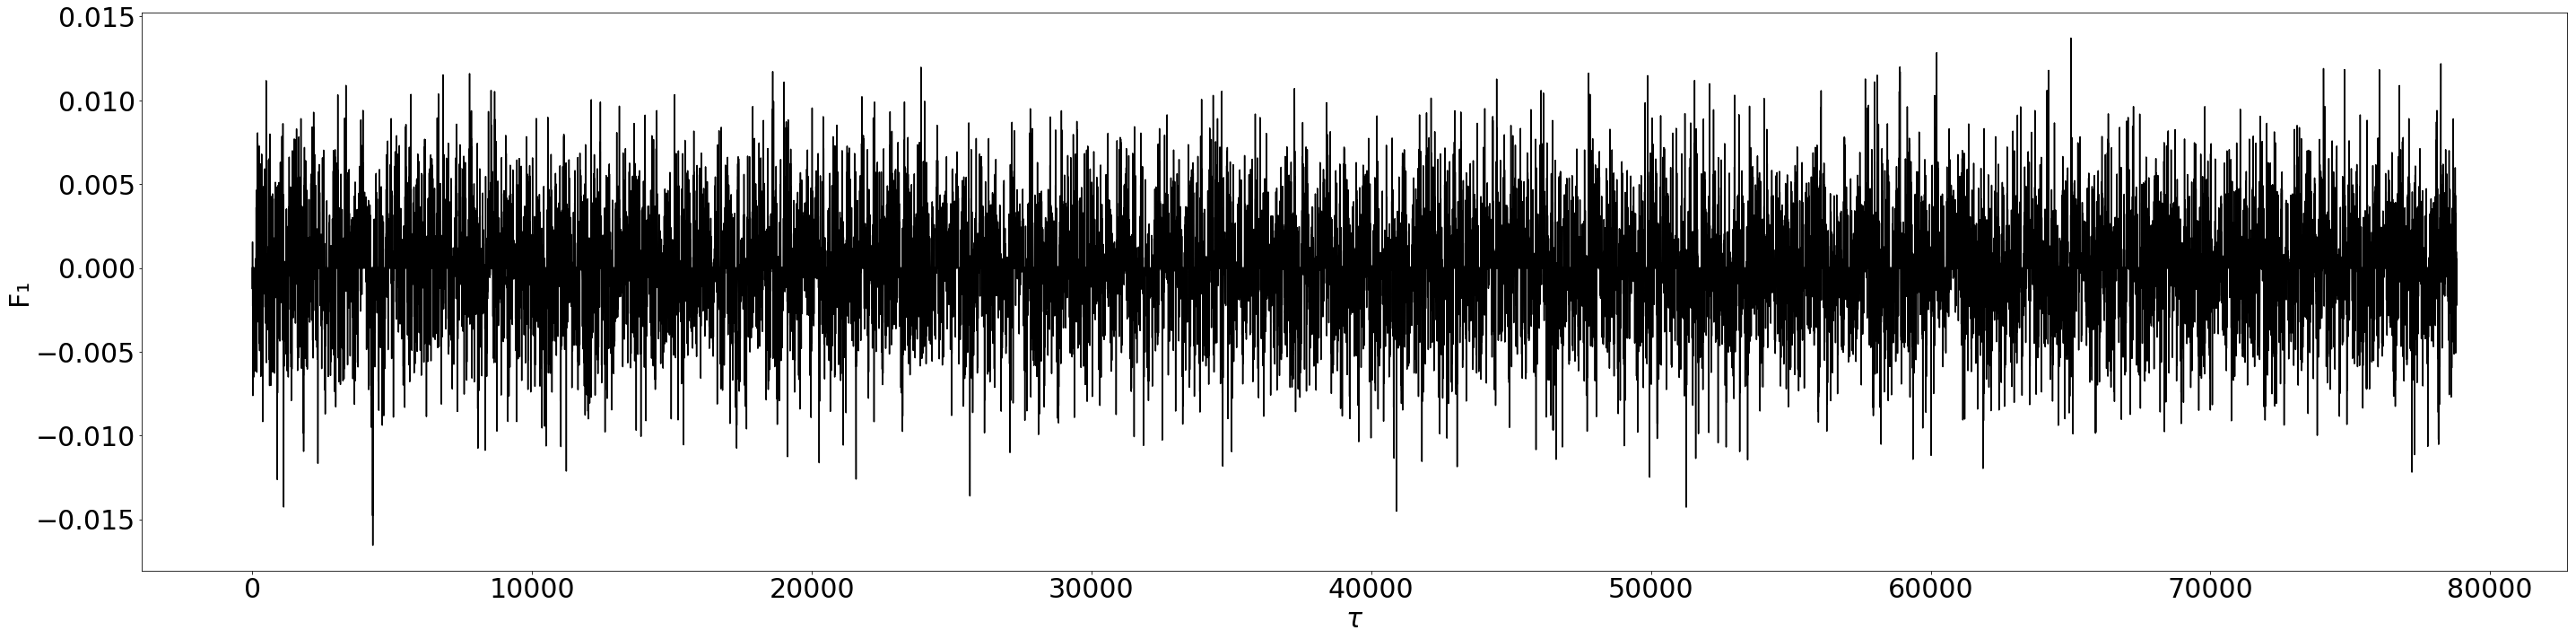

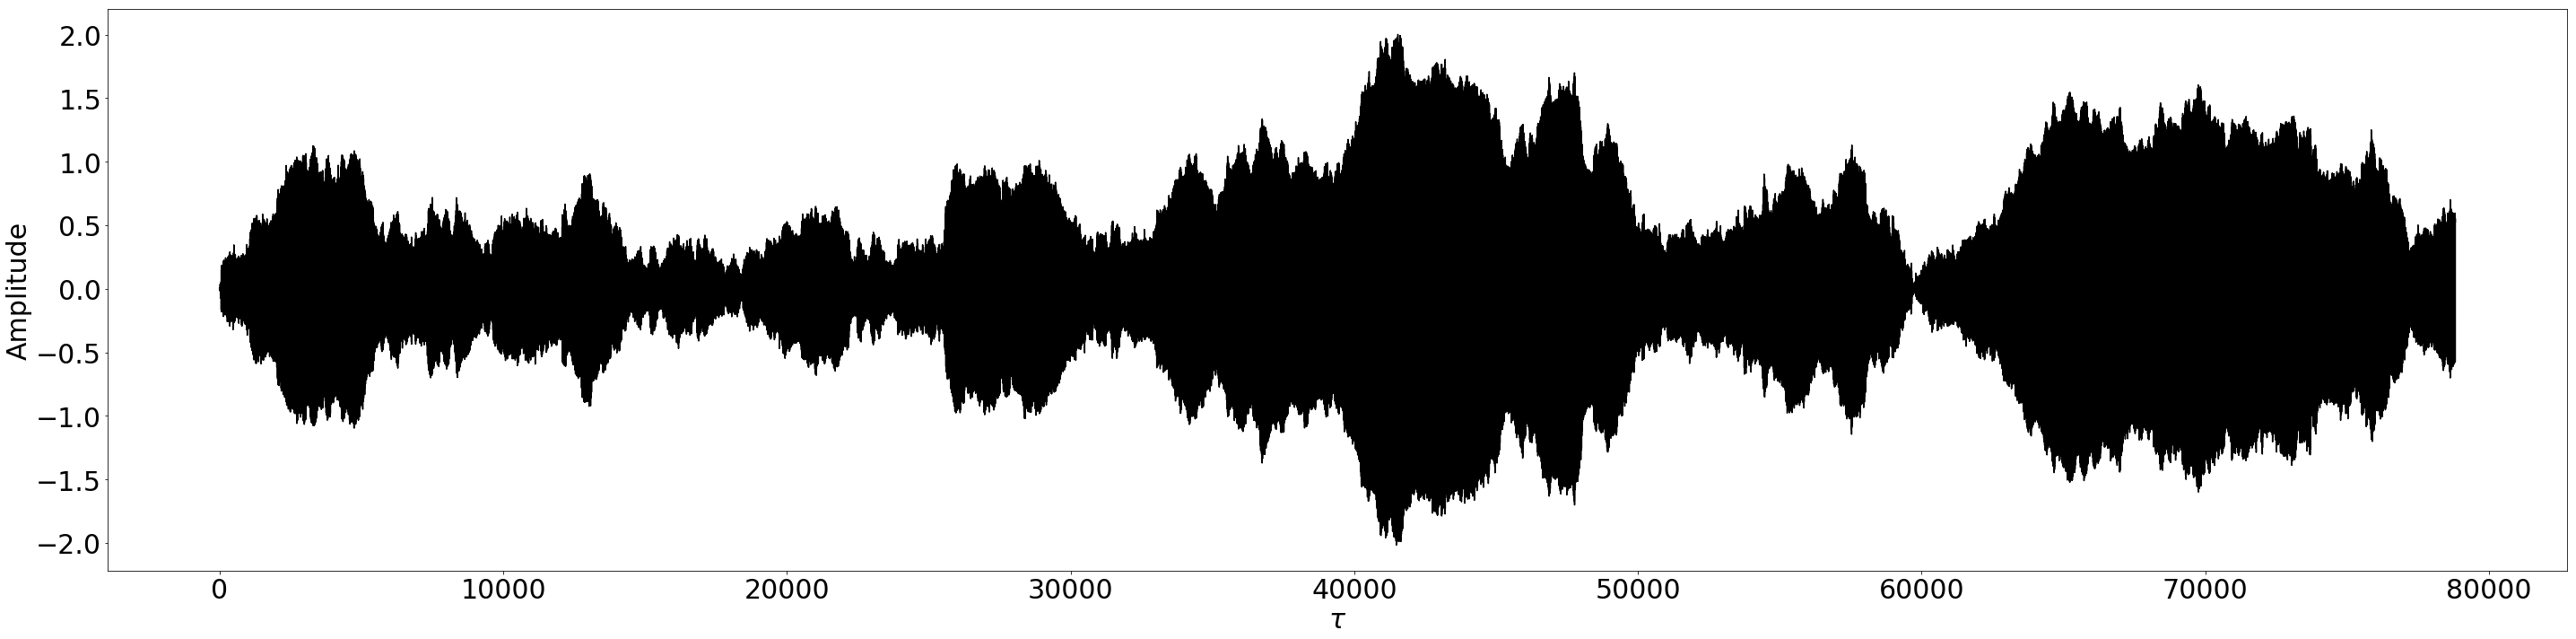

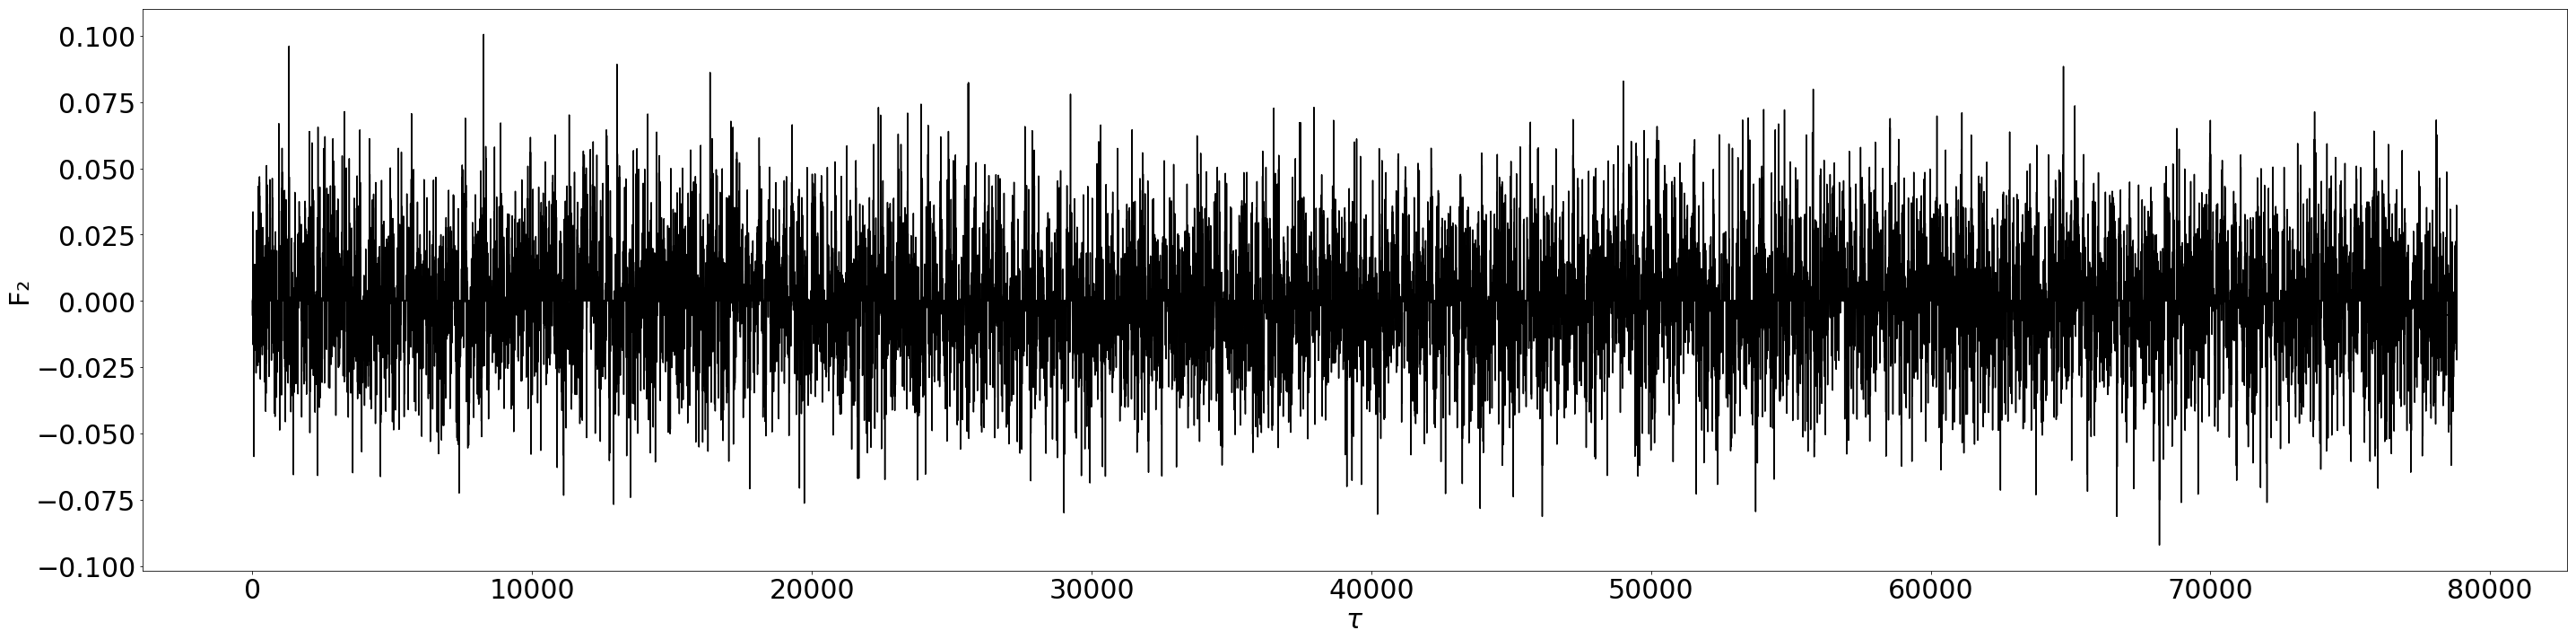

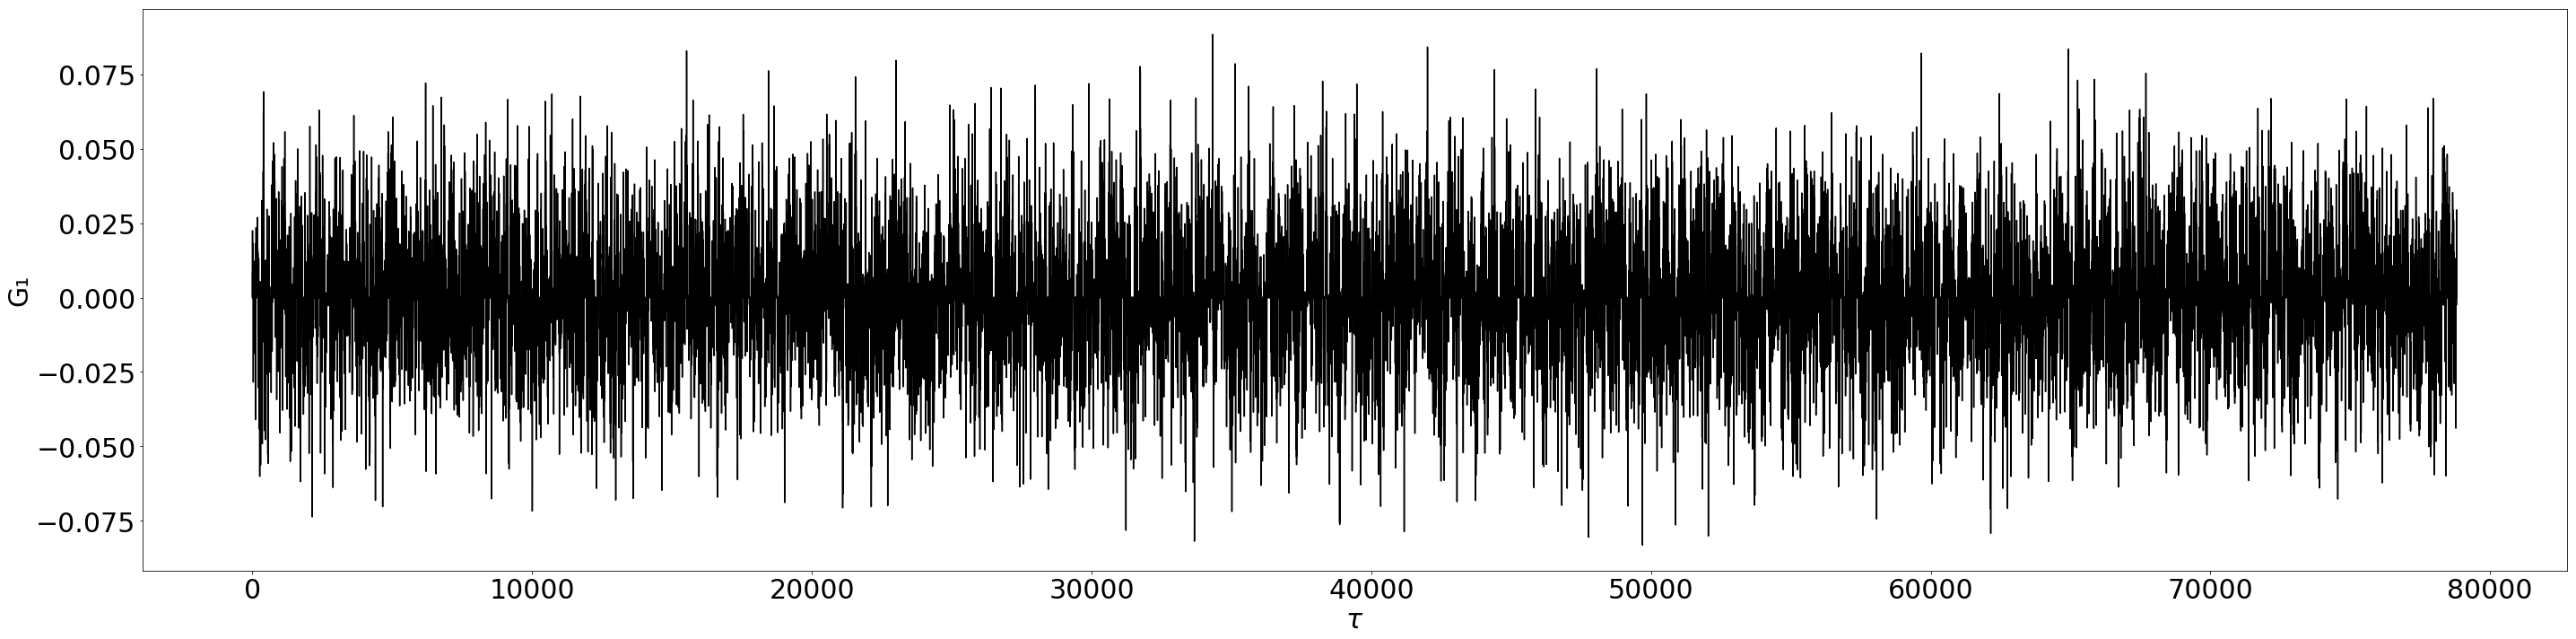

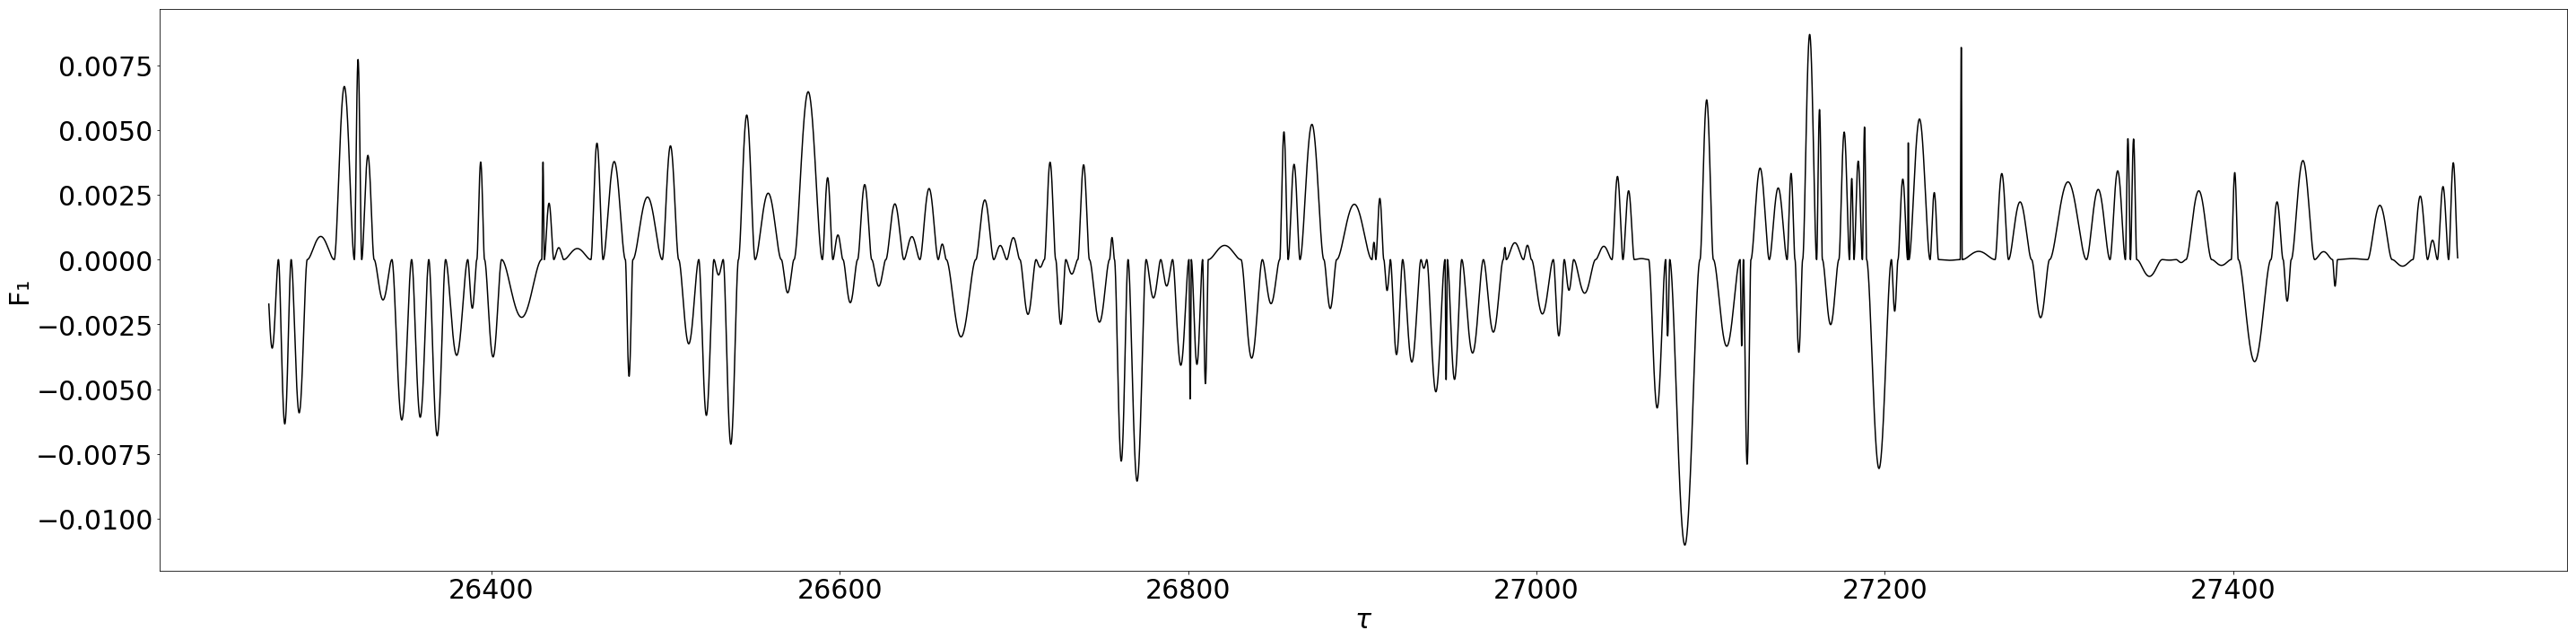

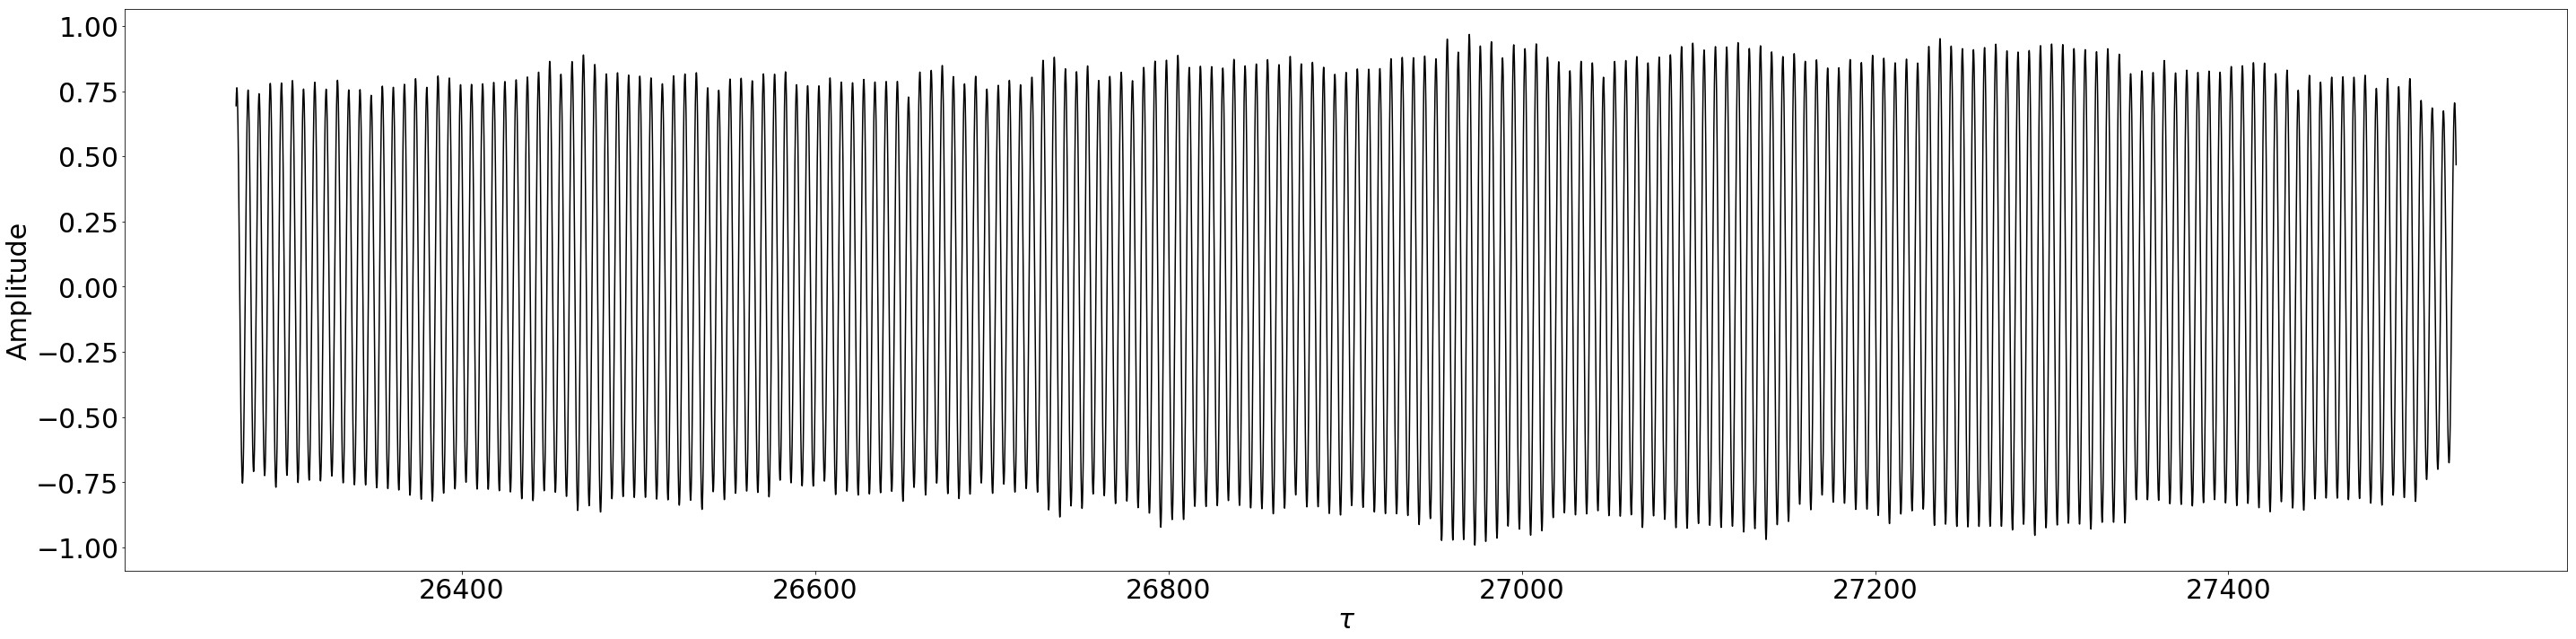

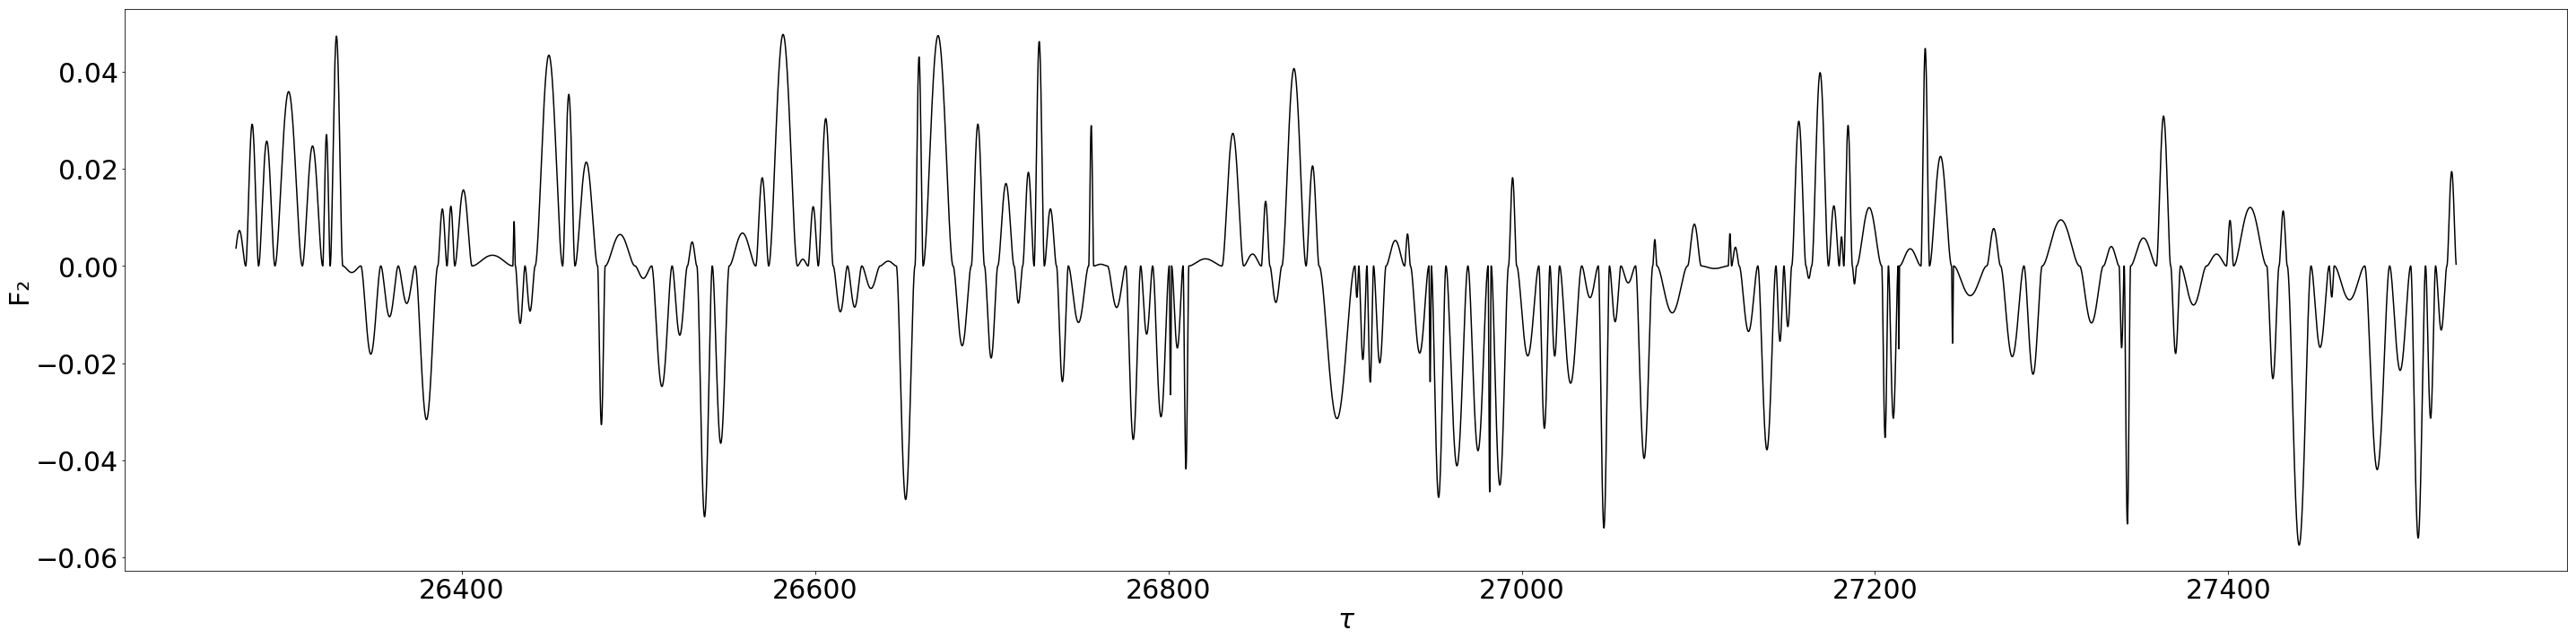

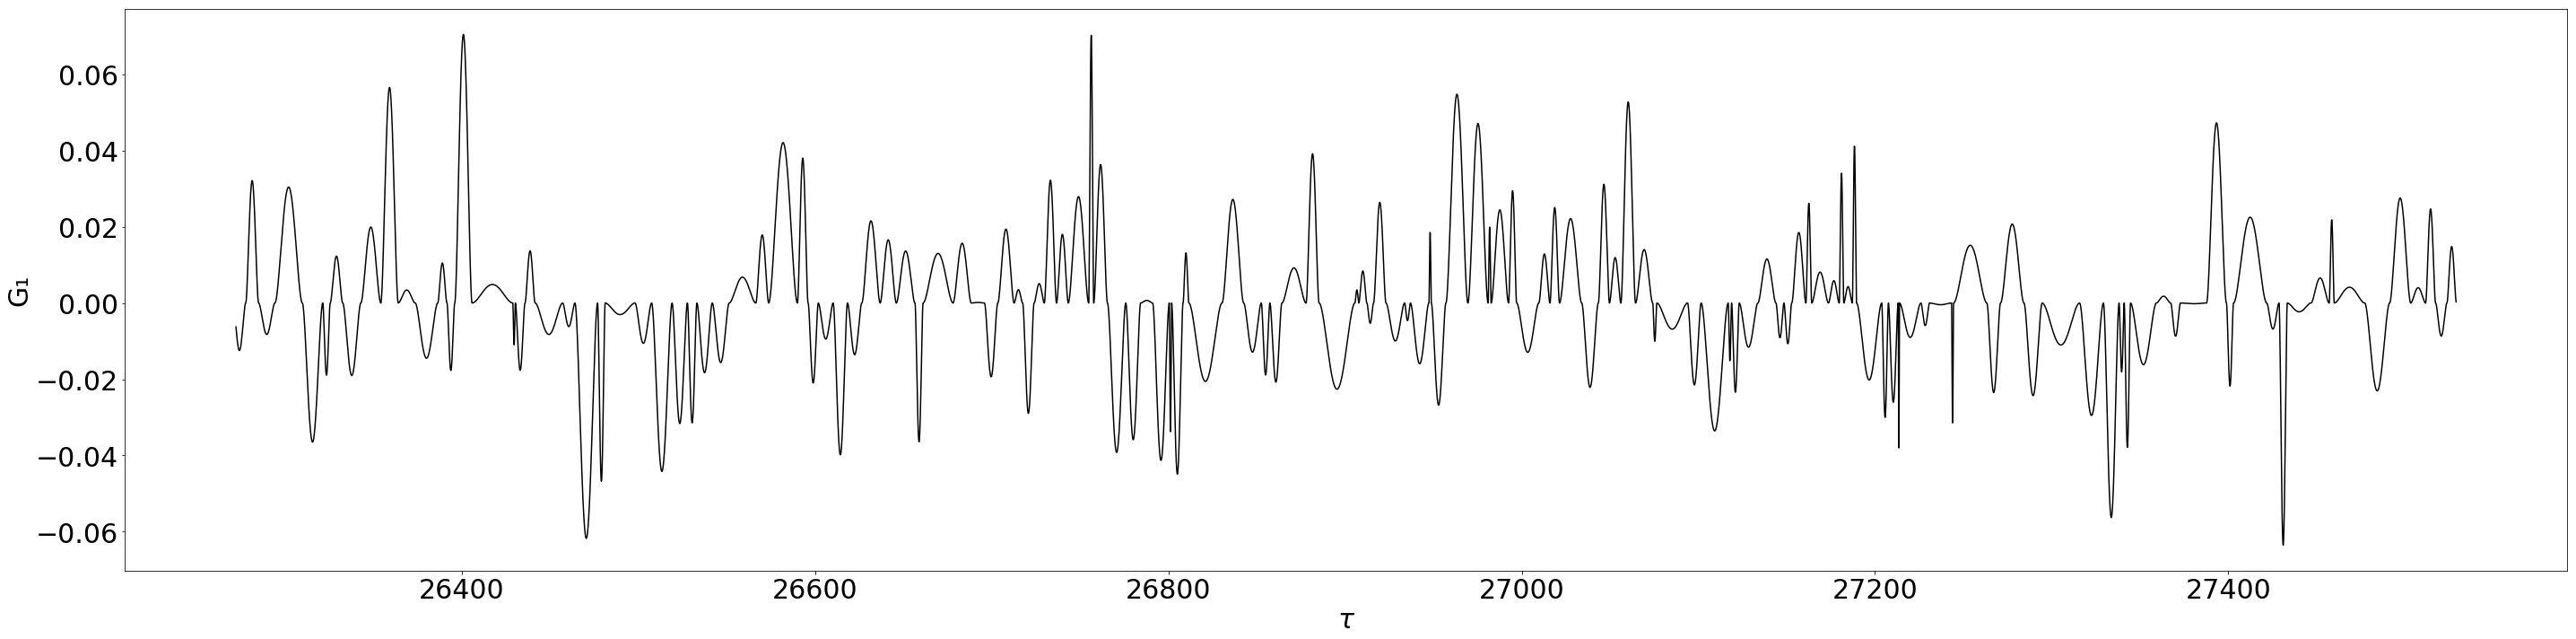

In [10]:
# total amp will contain the amplitudes of every run
total_Amp=[]

# generate F1
F1 = []
F1, time = funF_k(F1, stdF1, limitY1)

plt.hist(F1, 20)
plt.title("F1")
plt.show()

# generate F2
F2 = []
F2, time = funF_k(F2, stdF2, limitY2)

plt.hist(F2, 20)
plt.title("F2")
plt.show()

# generate G1
G1 = []
G1, time = funF_k(G1, stdF2, limitY2)

plt.hist(G1, 20)
plt.title("G1")
plt.show()

# generate Amp
# Amp with contain amplitudes of current run

Amp = [initial_AT]
 
Amp = funAmp(Amp, time)

total_Amp.append(Amp)
initial_AT = Amp[-1]

# plot all plots 
Funplots(time, Amp, F1, F2, G1)

# plot the shorter plot
duration = 2 * np.pi * M_short
tshort = []
Ashort = []
f1short = []
f2short = []
g1short = []
# start the shorter plot a third of the way through the run
start_index = int(len(time)/3)
index = start_index
while time[index] < (duration + time[start_index]):
    tshort.append(time[index])
    Ashort.append(Amp[index])
    f1short.append(F1[index])
    f2short.append(F2[index])
    g1short.append(G1[index])
    index +=1
    
# plot all plots 
Funplots(tshort, Ashort, f1short, f2short, g1short)

### Evolutions 2 - L

In [11]:
delt = N * deltaT

In [12]:
alpha = []

print("evolution 1 above")
print("\n")

# collecting nmax values of alpha from L evolutions
for i in range(L-1):
    print("evolution ", i+2)
    deltaT = fundeltaT(n_bins, M)
    Tturb, time = funTturb()
    F2=[]
    F1=[]
    G1=[]
    F2, time = funF_k(F2, stdF2, limitY2)
    F1, time = funF_k(F1, stdF1, limitY1)
    G1, time = funF_k(G1, stdF2, limitY2)
    Amp=[initial_AT]
    Amp = funAmp(Amp, time)
    initial_AT = Amp[-1]
    total_Amp.append(Amp)
    Funplots(time, Amp, F1, F2, G1)
    print("\n")

total_Amp = flatten(total_Amp)
funAlpha(total_Amp, time, alpha)
alpha = flatten(alpha)

evolution 1 above




## Amplification Distribution Function

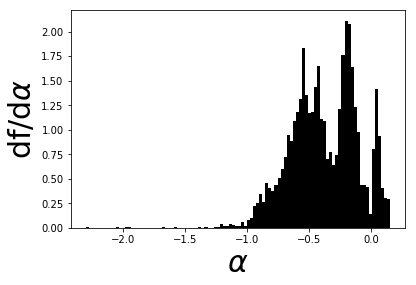

In [13]:
# divide the full range alpha_min <= alpha <= alpha_max into n equal intervals
# delalpha = (alpha_max - alpha_min) / n ~ 4/n

alpha_max = max(alpha)
alpha_min = min(alpha)
delalpha = (alpha_max - alpha_min) / m

# plot delf / delalpha vs. alpha
# where delf is the fraction of collected values of alpha within each bin of width delalpha

histogram = plt.hist(alpha, m, density=True, color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('df/d'r'$ \alpha $', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Cumulative Distribution Function

In [14]:
# CDF2 = int (df/dalpha) wrt dalpha from alpha to alpha_max
#      = 1 - CDF1
#      = 1 - int (df/dalpha) wrt dalpha from alpha_min to alpha

CDF2 = []
CDF1 = []

# alpha and dfdalpha values pulled from histogram above
alpha_values = histogram[1]
dfdalpha = histogram[0]
alpha_values = np.delete(alpha_values, 0)

index_max = len(alpha_values)-1

for index in range(len(dfdalpha)):
    index_start = index
    sum = 0
    for index_current in range(index_start, index_max):
        sum += dfdalpha[index_current] * alpha_values[index_current]
    CDF2.append(1-sum)
    CDF1.append(sum)
    
normalization_factor = CDF2[0]

CDF2_norm = []
for value in CDF2:
    CDF2_norm.append(value/normalization_factor)
    
CDF1_norm = []
for value in CDF1:
    CDF1_norm.append((value/normalization_factor)+1)
    
CDF2_norm = np.array(CDF2_norm)
CDF1_norm = np.array(CDF1_norm)

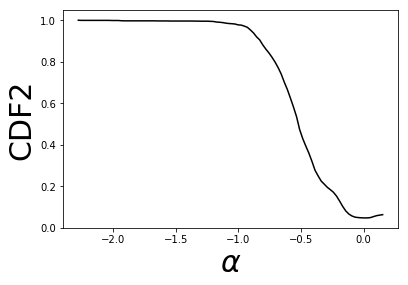

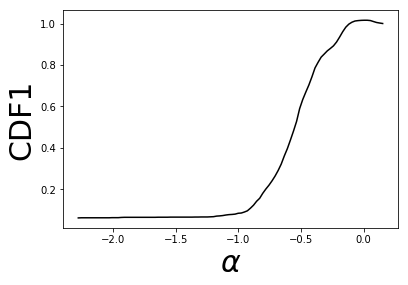

In [15]:
plt.plot(alpha_values, CDF2_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF2', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

plt.plot(alpha_values, CDF1_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF1', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Duty Cycle

In [16]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def duty_cycle(CDF2_norm, k):
    # finds where CDF2 = 1/2
    CDF2_median = find_nearest(CDF2_norm, 1/2)
    index_median =  np.where(CDF2_norm == CDF2_median)

    # finds alpha star
    alpha_star = alpha_values[index_median[0]]

    # finds CDF2(alpha_star + log(k))
    # alpha find is alpha_star+log(k)
    alpha_find = find_nearest(alpha_values, alpha_star + math.log(k, 10))
    index_find = np.where(alpha_values == alpha_find)
    
    psi = CDF2_norm[index_find]

    print("psi(", k, ") =", psi)

duty_cycle(CDF2_norm, 1)
duty_cycle(CDF2_norm, 5)

psi( 1 ) = [0.47301264]
psi( 5 ) = [0.06287903]


## Values for table

In [17]:
print("K = ", K)
print("eta * Ma**2 = ", eta * Ma**2)

print("\n")

F2rms = FunRMS(F2)
print("<F2^2>^(1/2) = ", F2rms)
print("Maximum Value of F2 ", max(F2))
print("Minimum Value of F2 ", min(F2))

print("\n")

F1rms = FunRMS(F1)
print("<F1^2>^(1/2) = ", F1rms)
print("Maximum Value of F1 ", max(F1)) 
print("Minimum Value of F1 ", min(F1))

print("\n")

G1rms = FunRMS(G1)
print("<G1^2>^(1/2) = ", G1rms)
print("Maximum Value of G1 ", max(G1)) 
print("Minimum Value of G1 ", min(G1))

print("\n")

Asqr = FunAsqr(total_Amp)
avg = np.sum(Asqr) / len(Asqr)
print("<A^2> = ", avg)

print("\n")

duty_cycle(CDF2_norm, 5)

K =  1
eta * Ma**2 =  0.025


<F2^2>^(1/2) =  0.015987718484475815
Maximum Value of F2  0.1005824829829506
Minimum Value of F2  -0.09214913759058063


<F1^2>^(1/2) =  0.0025052559516747135
Maximum Value of F1  0.013710295418442585
Minimum Value of F1  -0.0165482745511738


<G1^2>^(1/2) =  0.015686482012265163
Maximum Value of G1  0.08834119153581929
Minimum Value of G1  -0.08311669244013416


<A^2> =  0.37685382692302544


psi( 5 ) = [0.06287903]
